In [1]:
import matplotlib.pyplot as plt
import multiprocessing
import pathlib
from pprint import pprint
from typing import List

import fasttext
import gensim.models.word2vec
import gensim.utils
import pandas as pd

In [2]:
def print_table(
    headers: List[str], rows: List[List[str]], 
    latex: bool = False,
) -> None:
    """Print data rows in a table format."""
    if latex:
        df = pd.DataFrame(rows, columns=headers)
        print(df.to_latex())
        return
    
    # Get max cell width.
    max_len = max(len(h) for h in headers)
    for row in rows:
        max_len = max(max_len, *[len(r) for r in row])
    max_len += 1
    
    # Print header row.
    for header in headers:
        print(header.ljust(max_len), end="|")
    print()
    print("-"*(len(headers)*max_len + len(headers)))
    
    # Print content rows.
    for row in rows:
        for r in row:
            print(r.ljust(max_len), end="|")
        print()
    print()

In [3]:
frenchmed_file = "QUAERO_FrenchMed/QUAERO_FrenchMed_traindev.ospl"
frenchpress_file = "QUAERO_FrenchPress/QUAERO_FrenchPress_traindev.ospl"

In [4]:
from gensim.models.callbacks import CallbackAny2Vec

class W2VLogCallback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.prev_loss = 0
        self.history = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.history.append(loss - self.prev_loss)
        self.prev_loss = loss
        self.epoch += 1

In [5]:
def train_word2vec(
    filename: str,
    model: str = "cbow",
    dim: int = 100,
    min_count: int = 1,
    epochs: int = 10,
    alpha: float = 0.0025,
    sampling: float = 6e-5,
    min_alpha: float = 1e-5,
    n_workers: int = 8,
    window_size: int = 5,
    plot_learning_curve: bool = False,
) -> gensim.models.word2vec.Word2Vec:
    """Train gensim Word2Vec model on given corpus file.
    Returns trained model. 
    
    Parameters:
    -----------
        filename : str
            Path to corpus file.
        model : str
            Either `cbow` or `skipgram`.
        dim : int
            Size of the embedding vector.
        min_count : int
            Minimal occurence of the words to consider. 
        epochs : int
            Number of passess through the data set during training.
        alpha : float
            Initial learning rate. 
        min_alpha : float
            Minimal learning rate.
        n_workers : int
            Number of thread workers.
        window_size : int
            Window size to use.
            
    Returns:
    --------
    Gensim Word2Vec model.
    """
    
    # word2vec.Word2Vec(sentences=None, corpus_file=None, 
    # vector_size=100, alpha=0.025, window=5, min_count=5, 
    # max_vocab_size=None, sample=0.001, seed=1, workers=3, 
    # min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, 
    # cbow_mean=1, hashfxn=<built-in function hash>, epochs=5,  
    # null_word=0, trim_rule=None, sorted_vocab=1, 
    # batch_words=10000, compute_loss=False, callbacks=(), 
    # comment=None, max_final_vocab=None, shrink_windows=True)
    
    callback = W2VLogCallback()
    # Initialize empty Word2Vec model.
    w2v_model = gensim.models.word2vec.Word2Vec(
        vector_size=dim,
        min_count=min_count,
        sg=0 if model=="cbow" else 1,
        hs=0,
        negative=5,
        epochs=epochs,
        max_vocab_size=None, # no limit
        alpha=alpha, # initial alpha
        min_alpha=min_alpha, # minimal alpha
        workers=n_workers,
        window=window_size,
        sample=sampling,
    )
    
    # Build vocabulary from the source file.
    w2v_model.build_vocab(corpus_file=filename)
    # Run model training.
    w2v_model.train(
        corpus_file=filename,
        total_words=w2v_model.corpus_total_words, 
        epochs=w2v_model.epochs,
        report_delay=1,
        compute_loss=True,
        callbacks=[callback]
    )
    if plot_learning_curve:
        plt.plot(callback.history)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.grid()
        plt.show()
    return w2v_model

In [6]:
def train_fasttext(
    filename: str,
    model: str = "cbow",
    dim: int = 100,
    min_count: int = 1,
    epochs: int = 10,
    alpha: float = 0.0025,
    sampling: float = 0.0001,
    n_workers: int = 8,
    window_size: int = 5,
) -> fasttext.FastText._FastText:
    """Train fasttext Word2Vec model on given corpus file.
    Returns trained model. 
    
    Parameters:
    -----------
        filename : str
            Path to corpus file.
        model : str
            Either `cbow` or `skipgram`.
        dim : int
            Size of the embedding vector.
        min_count : int
            Minimal count occurence threshold for words.
        epochs : int
            Number of passess through the data set during training.
        alpha : float
            Initial learning rate. 
        n_workers : int
            Number of thread workers.
        window_size : int
            Window size to use.
            
    Returns:
    --------
    Fasttext Word2Vec model.
    """
    
#     input             # training file path (required)
#     model             # unsupervised fasttext model {cbow, skipgram} [skipgram]
#     lr                # learning rate [0.05]
#     dim               # size of word vectors [100]
#     ws                # size of the context window [5]
#     epoch             # number of epochs [5]
#     minCount          # minimal number of word occurences [5]
#     minn              # min length of char ngram [3]
#     maxn              # max length of char ngram [6]
#     neg               # number of negatives sampled [5]
#     wordNgrams        # max length of word ngram [1]
#     loss              # loss function {ns, hs, softmax, ova} [ns]
#     bucket            # number of buckets [2000000]
#     thread            # number of threads [number of cpus]
#     lrUpdateRate      # change the rate of updates for the learning rate [100]
#     t                 # sampling threshold [0.0001]
#     verbose           # verbose [2]
    
    w2v_model = fasttext.train_unsupervised(
        filename,
        model=model,
        dim=dim,
        lr=alpha,
        ws=window_size,
        epoch=epochs,
        minCount=min_count,
        t=sampling,
        thread=n_workers,
    )
    
    return w2v_model

## FrenchMed corpus

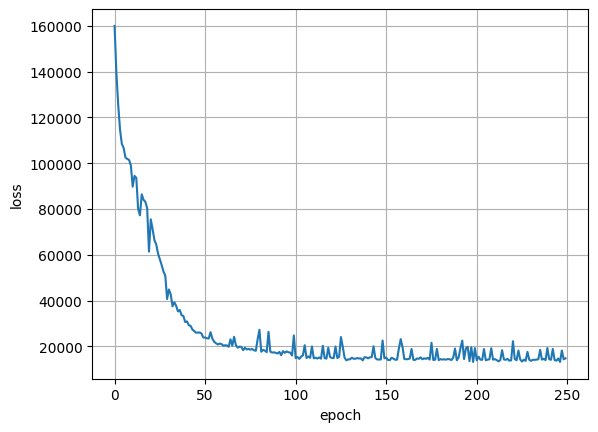

skipgram:  6578846.5


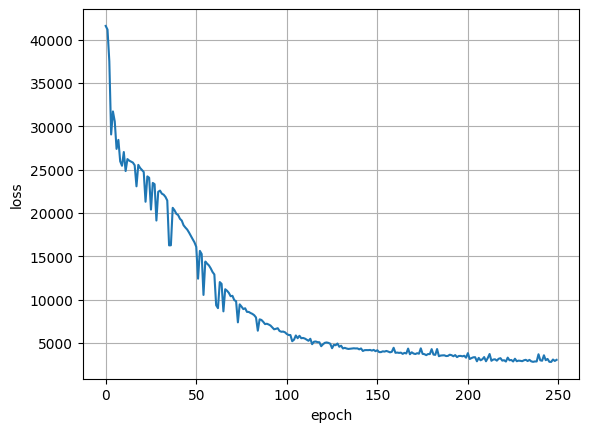

cbow:  2251372.75


Read 0M words
Number of words:  9105
Number of labels: 0
Progress: 100.0% words/sec/thread:  215783 lr:  0.000000 avg.loss:  1.255106 ETA:   0h 0m 0s


In [7]:
corpus_filename = frenchmed_file
n_workers = 4
dim = 100
n_epochs = 250
window_size = 5
min_count = 1

alpha = 0.025
min_alpha = 1e-4
sampling_threshold = 6e-5

# Train Gensim Word2Vec skipgram model.
w2v_skipgram = train_word2vec(
    corpus_filename,
    dim=dim,
    model="skipgram",
    epochs=n_epochs,
    alpha=alpha,
    min_alpha=min_alpha,
    n_workers=n_workers,
    window_size=window_size,
    min_count=min_count,
    sampling=sampling_threshold,
    plot_learning_curve=True,
)
print("skipgram: ", w2v_skipgram.get_latest_training_loss())
# Train Gensim Word2Vec CBOW model.
w2v_cbow = train_word2vec(
    corpus_filename,
    dim=dim,
    model="cbow",
    epochs=n_epochs,
    alpha=alpha,
    min_alpha=min_alpha,
    n_workers=n_workers,
    window_size=window_size,
    min_count=min_count,
    sampling=sampling_threshold,
    plot_learning_curve=True,
)
print("cbow: ", w2v_cbow.get_latest_training_loss())
# Train Fasttext Word2Vec CBOW model.
fast_cbow = train_fasttext(
    corpus_filename,
    dim=dim,
    model="cbow",
    alpha=alpha,
    epochs=n_epochs,
    min_count=min_count,
    window_size=window_size,
    sampling=sampling_threshold,
    n_workers=n_workers,
)

In [8]:
words = "patient, traitement, maladie, solution, jaune".split(", ")
headers = ("word2vec skipgram", "word2vec cbow", "fasttext cbow")
for word in words:
    print("Closest neighbors for:", word)
    
    cl_w2v_skipgram = [
        p[0] for p in w2v_skipgram.wv.most_similar(word, topn=10)]
    cl_w2v_cbow = [
        p[0] for p in w2v_cbow.wv.most_similar(word, topn=10)]
    cl_ftx_cbow = [
        p[1] for p in fast_cbow.get_nearest_neighbors(word, 10)]
    
    print_table(
        headers, 
        list(zip(cl_w2v_skipgram, cl_w2v_cbow, cl_ftx_cbow)), 
        latex=True,
    )

Closest neighbors for: patient
\begin{tabular}{llll}
\toprule
{} & word2vec skipgram &  word2vec cbow & fasttext cbow \\
\midrule
0 &       stimulateur &        Montrez &       Patient \\
1 &             repos &          carte &      parvient \\
2 &          encourus &         alerte &     maintient \\
3 &           souffre &       attentif &    recevaient \\
4 &      gériatriques &        souffre &       avaient \\
5 &        rencontrés &  soigneusement &         aient \\
6 &         certitude &     évocateurs &        soient \\
7 &         trouverez &      certitude &      Contient \\
8 &             Carte &      symptômes &      gradient \\
9 &        déterminer &           afin &     excipient \\
\bottomrule
\end{tabular}

Closest neighbors for: traitement
\begin{tabular}{llll}
\toprule
{} & word2vec skipgram & word2vec cbow &  fasttext cbow \\
\midrule
0 &           Reprise &          être &     Traitement \\
1 &                le &          doit &      traitment \\
2 &       Thor

/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to us

## FrenchPress corpus

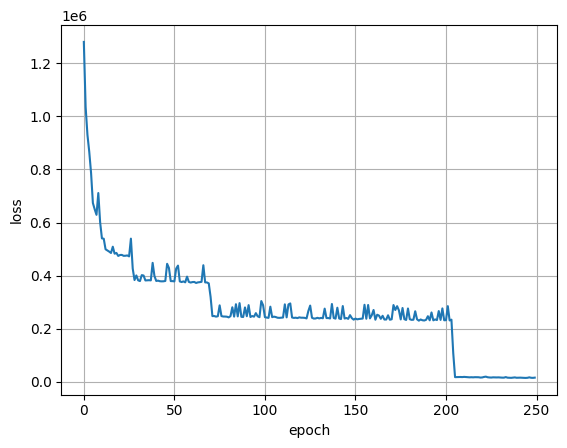

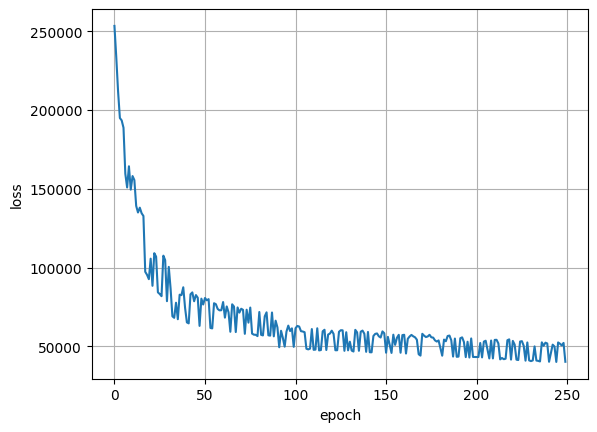

Read 1M words
Number of words:  39655
Number of labels: 0
Progress: 100.0% words/sec/thread:  156604 lr:  0.000000 avg.loss:  1.085936 ETA:   0h 0m 0s


In [9]:
# Train 3 models on Medical dataset and compare
corpus_filename = frenchpress_file
n_workers = multiprocessing.cpu_count() - 1
dim = 100
n_epochs = 250
window_size = 5
min_count = 1

alpha = 0.025
min_alpha = 1e-4
sampling_threshold = 6e-5

# Train Gensim Word2Vec skipgram model.
w2v_skipgram_press = train_word2vec(
    corpus_filename,
    dim=dim,
    model="skipgram",
    epochs=n_epochs,
    alpha=alpha,
    min_alpha=min_alpha,
    n_workers=n_workers,
    window_size=window_size,
    min_count=min_count,
    sampling=sampling_threshold,
    plot_learning_curve=True,
)
# Train Gensim Word2Vec CBOW model.
w2v_cbow_press = train_word2vec(
    corpus_filename,
    dim=dim,
    model="cbow",
    epochs=n_epochs,
    alpha=alpha,
    min_alpha=min_alpha,
    n_workers=n_workers,
    window_size=window_size,
    min_count=min_count,
    sampling=sampling_threshold,
    plot_learning_curve=True,
)
# Train Fasttext Word2Vec CBOW model.
fast_cbow_press = train_fasttext(
    corpus_filename,
    dim=dim,
    model="cbow",
    alpha=alpha,
    epochs=n_epochs,
    min_count=min_count,
    window_size=window_size,
    sampling=sampling_threshold,
    n_workers=n_workers,
)

In [10]:
words = "patient, traitement, maladie, solution, jaune".split(", ")
headers = ("word2vec skipgram", "word2vec cbow", "fasttext cbow")
for word in words:
    print("Closest neighbors for:", word)
    
    cl_w2v_skipgram = [
        p[0] for p in w2v_skipgram_press.wv.most_similar(word, topn=10)]
    cl_w2v_cbow = [
        p[0] for p in w2v_cbow_press.wv.most_similar(word, topn=10)]
    cl_ftx_cbow = [
        p[1] for p in fast_cbow_press.get_nearest_neighbors(word, 10)]
    
    print_table(
        headers, 
        list(zip(cl_w2v_skipgram, cl_w2v_cbow, cl_ftx_cbow)), 
        latex=True,
    )

Closest neighbors for: patient
\begin{tabular}{llll}
\toprule
{} & word2vec skipgram &  word2vec cbow & fasttext cbow \\
\midrule
0 &       infantilisé &    hospitalisé &    patientent \\
1 &       hospitalisé &      contaminé &     impatient \\
2 &         cancéreux &      cancéreux &      patiente \\
3 &          soignant &          livré &      patients \\
4 &          extraire &         ricane &  impatientent \\
5 &            humble &    infantilisé &    patiemment \\
6 &        palliatifs &       soignant &    impatiente \\
7 &           polluée &    séropositif &    patientera \\
8 &           bas-âge &       déboutés &     patienter \\
9 &     interpénétrer &  interpénétrer &      patience \\
\bottomrule
\end{tabular}

Closest neighbors for: traitement
\begin{tabular}{llll}
\toprule
{} & word2vec skipgram &  word2vec cbow &   fasttext cbow \\
\midrule
0 &         gériatrie &      gériatrie &     traitements \\
1 &      anti-douleur &    antidouleur &    retraitement \\
2 &     

/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to us

## Investigating data influence

In [11]:
print("Comparison for Word2Vec Skipgram")
words = "patient, traitement, maladie, solution, jaune".split(", ")
headers = ("FrenchMed", "FrenchPress")
for word in words:
    print("Closest neighbors for:", word)
    
    med_skipgram = [
        p[0] for p in w2v_skipgram.wv.most_similar(word, topn=10)]
    press_skipgram = [
        p[0] for p in w2v_skipgram_press.wv.most_similar(word, topn=10)]
    print_table(
        headers, 
        list(zip(med_skipgram, press_skipgram)), 
        latex=True,
    )

Comparison for Word2Vec Skipgram
Closest neighbors for: patient
\begin{tabular}{lll}
\toprule
{} &     FrenchMed &    FrenchPress \\
\midrule
0 &   stimulateur &    infantilisé \\
1 &         repos &    hospitalisé \\
2 &      encourus &      cancéreux \\
3 &       souffre &       soignant \\
4 &  gériatriques &       extraire \\
5 &    rencontrés &         humble \\
6 &     certitude &     palliatifs \\
7 &     trouverez &        polluée \\
8 &         Carte &        bas-âge \\
9 &    déterminer &  interpénétrer \\
\bottomrule
\end{tabular}

Closest neighbors for: traitement
\begin{tabular}{lll}
\toprule
{} &     FrenchMed &     FrenchPress \\
\midrule
0 &       Reprise &       gériatrie \\
1 &            le &    anti-douleur \\
2 &   Thoraciques &          Ahivor \\
3 &      agrafage &  asservissement \\
4 &     définitif &         Palmade \\
5 &        volets &    Lariboisière \\
6 &        aphtes &         Bergman \\
7 &   péricardite &   impose-t-elle \\
8 &    paralysies &   médi

/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to us

In [12]:
print("Comparison for Word2Vec CBOW")
words = "patient, traitement, maladie, solution, jaune".split(", ")
headers = ("FrenchMed", "FrenchPress")
for word in words:
    print("Closest neighbors for:", word)
    
    med_cbow = [
        p[0] for p in w2v_cbow.wv.most_similar(word, topn=10)]
    press_cbow = [
        p[0] for p in w2v_cbow_press.wv.most_similar(word, topn=10)]
    print_table(
        headers, 
        list(zip(med_cbow, press_cbow)), 
        latex=True,
    )

/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


Comparison for Word2Vec CBOW
Closest neighbors for: patient
\begin{tabular}{lll}
\toprule
{} &      FrenchMed &    FrenchPress \\
\midrule
0 &        Montrez &    hospitalisé \\
1 &          carte &      contaminé \\
2 &         alerte &      cancéreux \\
3 &       attentif &          livré \\
4 &        souffre &         ricane \\
5 &  soigneusement &    infantilisé \\
6 &     évocateurs &       soignant \\
7 &      certitude &    séropositif \\
8 &      symptômes &       déboutés \\
9 &           afin &  interpénétrer \\
\bottomrule
\end{tabular}

Closest neighbors for: traitement
\begin{tabular}{lll}
\toprule
{} &  FrenchMed &    FrenchPress \\
\midrule
0 &       être &      gériatrie \\
1 &       doit &    antidouleur \\
2 &   patients &      inégalité \\
3 &        par &       cohérent \\
4 &     Tasmar &    générateurs \\
5 &    médecin &  médicamenteux \\
6 &   instauré &   anti-douleur \\
7 &      prise &       remédier \\
8 &   détecter &      royalties \\
9 &  nécessité &    

/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to us

In [13]:
print("Comparison for Fasttext CBOW")
words = "patient, traitement, maladie, solution, jaune".split(", ")
headers = ("FrenchMed", "FrenchPress")
for word in words:
    print("Closest neighbors for:", word)
    
    med_fasttext = [
        p[1] for p in fast_cbow.get_nearest_neighbors(word, 10)]
    press_fasttext = [
        p[1] for p in fast_cbow_press.get_nearest_neighbors(word, 10)]
    print_table(
        headers, 
        list(zip(med_fasttext, press_fasttext)), 
        latex=True,
    )

Comparison for Fasttext CBOW
Closest neighbors for: patient


/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


\begin{tabular}{lll}
\toprule
{} &   FrenchMed &   FrenchPress \\
\midrule
0 &     Patient &    patientent \\
1 &    parvient &     impatient \\
2 &   maintient &      patiente \\
3 &  recevaient &      patients \\
4 &     avaient &  impatientent \\
5 &       aient &    patiemment \\
6 &      soient &    impatiente \\
7 &    Contient &    patientera \\
8 &    gradient &     patienter \\
9 &   excipient &      patience \\
\bottomrule
\end{tabular}

Closest neighbors for: traitement
\begin{tabular}{lll}
\toprule
{} &      FrenchMed &     FrenchPress \\
\midrule
0 &     Traitement &     traitements \\
1 &      traitment &    retraitement \\
2 &     Taaitement &  maladroitement \\
3 &    Allaitement &      subitement \\
4 &    étroitement &     étroitement \\
5 &    allaitement &        bêtement \\
6 &      évitement &          traite \\
7 &  immédiatement &         traiter \\
8 &    recrutement &      dépècement \\
9 &   correctement &        traitent \\
\bottomrule
\end{tabular}

Closest

/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to us

## FrenchMed with preprocessed text

In [14]:
new_frenchmed = frenchmed_file.split("/")[:-1] + ["new_FrenchMed.ospl"]
new_frenchmed_fname = "/".join(new_frenchmed)

frenchmed = pathlib.Path(frenchmed_file)
new_frenchmed = pathlib.Path(new_frenchmed_fname)

with frenchmed.open("r", encoding="utf-8") as original_file:
    with new_frenchmed.open("w", encoding="utf-8") as new_file:
        for line in original_file:
            # Rewrite the content of medical corpus to a new 
            # file using gensim.utils.simple_preprocess as
            # pre-processing.
            new_line = gensim.utils.simple_preprocess(line)
            new_file.write(" ".join(new_line) + "\n")

In [15]:
new_frenchmed_fname

'QUAERO_FrenchMed/new_FrenchMed.ospl'

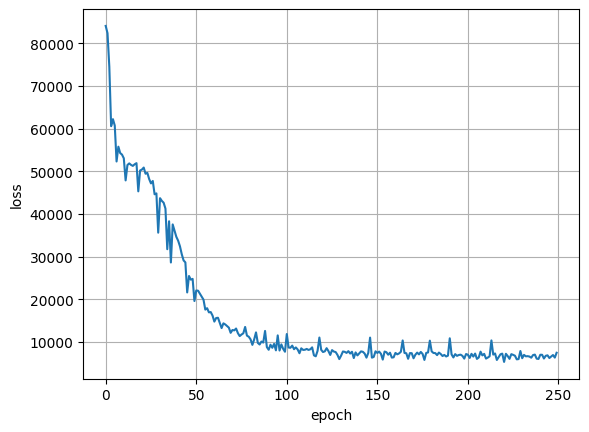

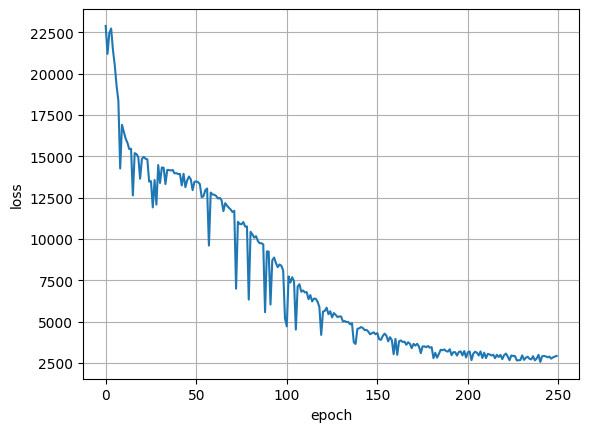

Read 0M words
Number of words:  7393
Number of labels: 0
Progress: 100.0% words/sec/thread:  202903 lr:  0.000000 avg.loss:  1.355758 ETA:   0h 0m 0s


In [16]:
corpus_filename = new_frenchmed_fname
n_workers = 4
dim = 100
n_epochs = 250
window_size = 5
min_count = 1

alpha = 0.025
min_alpha = 1e-4
sampling_threshold = 6e-5

# Train Gensim Word2Vec skipgram model.
w2v_skipgram_new = train_word2vec(
    corpus_filename,
    dim=dim,
    model="skipgram",
    epochs=n_epochs,
    alpha=alpha,
    min_alpha=min_alpha,
    n_workers=n_workers,
    window_size=window_size,
    min_count=min_count,
    sampling=sampling_threshold,
    plot_learning_curve=True,
)
# Train Gensim Word2Vec CBOW model.
w2v_cbow_new = train_word2vec(
    corpus_filename,
    dim=dim,
    model="cbow",
    epochs=n_epochs,
    alpha=alpha,
    min_alpha=min_alpha,
    n_workers=n_workers,
    window_size=window_size,
    min_count=min_count,
    sampling=sampling_threshold,
    plot_learning_curve=True,
)
# Train Fasttext Word2Vec CBOW model.
fast_cbow_new = train_fasttext(
    corpus_filename,
    dim=dim,
    model="cbow",
    alpha=alpha,
    epochs=n_epochs,
    min_count=min_count,
    window_size=window_size,
    sampling=sampling_threshold,
    n_workers=n_workers,
)

In [17]:
words = "patient, traitement, maladie, solution, jaune".split(", ")
headers = ("word2vec skipgram", "word2vec cbow", "fasttext cbow")
for word in words:
    print("Closest neighbors for:", word)
    
    cl_w2v_skipgram = [
        p[0] for p in w2v_skipgram_new.wv.most_similar(word, topn=10)]
    cl_w2v_cbow = [
        p[0] for p in w2v_cbow_new.wv.most_similar(word, topn=10)]
    cl_ftx_cbow = [
        p[1] for p in fast_cbow_new.get_nearest_neighbors(word, 10)]
    
    print_table(
        headers, 
        list(zip(cl_w2v_skipgram, cl_w2v_cbow, cl_ftx_cbow)), 
        latex=True,
    )

Closest neighbors for: patient
\begin{tabular}{llll}
\toprule
{} & word2vec skipgram & word2vec cbow & fasttext cbow \\
\midrule
0 &       stimulateur &       montrez &      parvient \\
1 &          encourus &         carte &       avaient \\
2 &          attentif &        alerte &      ajoutent \\
3 &           souffre &      attentif &     maintient \\
4 &            remise &        remise &         aient \\
5 &          courants &       souffre &    recevaient \\
6 &             repos &         devra &        soient \\
7 &         certitude &     certitude &       doivent \\
8 &         existante &      éliminer &       souvent \\
9 &           montrez &           que &      gradient \\
\bottomrule
\end{tabular}

Closest neighbors for: traitement
\begin{tabular}{llll}
\toprule
{} & word2vec skipgram & word2vec cbow &  fasttext cbow \\
\midrule
0 &                le &      instauré &      traitment \\
1 &               par &     surveillé &     taaitement \\
2 &                du &  

/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
/tmp/ipykernel_62926/3983612798.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to us